In [5]:
import pyiast
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import pickle
import time
import os
import scipy.optimize as optim
import matplotlib.pyplot as plt

In [6]:
os.listdir()

['.git',
 '.gitattributes',
 '.ipynb_checkpoints',
 '.vscode',
 'AEI_Isotherm.png',
 'AEI_Isotherm_lowP.png',
 'CO2_00per_ov.csv',
 'CO2_100per_ov.csv',
 'CO2_200per_ov.csv',
 'CO2_50per_ov.csv',
 'CO2_Purity_PSA_1vs9.png',
 'Compare_Isotherm_param.ipynb',
 'data100.bin',
 'data200.bin',
 'data50.bin',
 'GCMC_IWR_0_CO2_CH4.csv',
 'GCMC_IWR_0_H2S_CH4.csv',
 'H2S_00per_ov.csv',
 'H2S_100per_ov.csv',
 'H2S_200per_ov.csv',
 'H2S_50per_ov.csv',
 'H2S_Purity_PSA_2vs8.png',
 'HEAT_0215.csv',
 'HTS_346_210311.csv',
 'HTS_346_GCMC_Selectivity_210312.csv',
 'IAST_50bar_mixture_isotherm_previous',
 'IAST_selectivity_to_csv_0311.ipynb',
 'IAST_sel_Focus_0315.ipynb',
 'IAST_targ_CASE1_CH4.csv',
 'IAST_targ_CASE1_CO2.csv',
 'IAST_targ_CASE2_CH4.csv',
 'IAST_targ_CASE2_H2S.csv',
 'IAST_uptake_CO2.csv',
 'IAST_uptake_H2S.csv',
 'iso_ACO_0_saved.bin',
 'iso_AEI_0_saved.bin',
 'iso_AEI_1_saved.bin',
 'iso_AEL_0_saved.bin',
 'iso_AEL_1_saved.bin',
 'iso_AEL_2_saved.bin',
 'iso_AET_0_saved.bin',
 'iso_AET

In [7]:
df_NAME=pd.read_csv("HEAT_0215.csv")

bins_CO2 = []
bins_H2S = []
for nam in df_NAME["NAME"]:
    f_tmp = open("iso_"+nam+"_saved.bin",'rb')
    bin_tmp = np.array(pickle.load(f_tmp))
    bins_CO2.append(bin_tmp[[False, True, True]]) ## Pick 1 = CO2, 2 = CH4 
    f_tmp.close()
for nam in df_NAME["NAME"]:
    f_tmp = open("iso_"+nam+"_saved.bin",'rb') ## 0 = H2S , 1 = CO2, 2 = CH4
    bin_tmp = np.array(pickle.load(f_tmp))
    bins_H2S.append(bin_tmp[[True, False, True]]) ## Pick 0 = H2S and 2 = CH4
    f_tmp.close()

Names_CO2=df_NAME["NAME"].to_numpy()
Names_H2S=df_NAME["NAME"].to_numpy()
dH_CO2 = np.array([df_NAME["CO2_Heat"], df_NAME["CH4_Heat"]]).T
dH_H2S = np.array([df_NAME["H2S_Heat"],df_NAME["CH4_Heat"]]).T

# Functions

## iso_mix: Mixture Isotherm

In [8]:
Arrh = lambda T,dH ,T_ref: np.exp(-dH/8.3145*(1/T - 1/T_ref)) # Arrhenius equation (Clasius-Clapeyron Equation)

## Isothermal mixture isotherm
def iso_mix(P_par, T, iso_list, dH_list,Tref_list):
    P_norm = []
    for (p,dh,tref) in zip(P_par, dH_list,Tref_list):
        p_n = Arrh(T,dh,tref)*p 
        P_norm.append(p_n)
    P_norm_arr = np.array(P_norm)
    #print(P_norm_mat.T)
    if P_norm_arr.ndim > 1:
        for i in range(len(P_norm[0])):
            p_tmp = P_norm_arr[i,:]
            p_tmp[p_tmp<0.000001] = 0.000001
            q_IAST_tmp = pyiast.iast(p_tmp,
                                     iso_list,
                                     warningoff=True)
    else:
        try:
            p_tmp = P_norm_arr
            p_tmp[p_tmp<0.000001] = 0.000001
            #print(p_tmp)
            q_IAST_tmp = pyiast.iast(p_tmp,
                                    iso_list,
                                     warningoff=True)
        except:    
            try:
                #print('Initial guess error with P = ',P_par)
                x_IG = np.ones(len(p_tmp))/len(p_tmp)
                q_IAST_tmp = pyiast.iast(p_tmp,
                                        iso_list,adsorbed_mole_fraction_guess = x_IG,
                                        warningoff=True)
            except:
                try:
                    arg_min = np.argmin(p_tmp)
                    p_tmp[p_tmp<0.000001] = 0.000001
                    x_IG = 0.05*np.ones(len(p_tmp))
                    x_IG[arg_min] = 1 - 0.05*(len(p_tmp)-1)
                    #print(x_IG)
                    q_IAST_tmp = pyiast.iast(p_tmp,
                                            iso_list,adsorbed_mole_fraction_guess = x_IG,
                                            warningoff=True)

                except:
                    try:
                        arg_max = np.argmax(p_tmp)
                        p_tmp[p_tmp<0.000001] = 0.000001
                        x_IG = 0.05*np.ones(len(p_tmp))
                        x_IG[arg_max] = 1 - 0.05*(len(p_tmp)-1)
                        #print(x_IG)
                        q_IAST_tmp = pyiast.iast(p_tmp,
                                                iso_list,adsorbed_mole_fraction_guess = x_IG,
                                                warningoff=True)        
                    except:
                        try:
                            arg_max = np.argmax(p_tmp)
                            p_tmp[p_tmp<0.000001] = 0.000001
                            x_IG = 0.15*np.ones(len(p_tmp))
                            x_IG[arg_max] = 1 - 0.15*(len(p_tmp)-1)
                            #print(x_IG)
                            q_IAST_tmp = pyiast.iast(p_tmp,
                                                iso_list,adsorbed_mole_fraction_guess = x_IG,
                                                warningoff=True)
                        except:
                            try:
                                arg_min = np.argmin(p_tmp)
                                p_tmp[p_tmp<0.000001] = 0.000001
                                x_IG = 0.01*np.ones(len(p_tmp))
                                x_IG[arg_min] = 1 - 0.01*(len(p_tmp)-1)
                                #print(x_IG)
                                q_IAST_tmp = pyiast.iast(p_tmp,
                                            iso_list,adsorbed_mole_fraction_guess = x_IG,
                                            warningoff=True)

                            except:
                                try:
                                    arg_max = np.argmax(p_tmp)
                                    p_tmp[p_tmp<0.000001] = 0.000001
                                    x_IG = 0.01*np.ones(len(p_tmp))
                                    x_IG[arg_max] = 1 - 0.01*(len(p_tmp)-1)
                                    #print(x_IG)
                                    q_IAST_tmp = pyiast.iast(p_tmp,
                                                    iso_list,adsorbed_mole_fraction_guess = x_IG,
                                                warningoff=True)        
                                except:
                                    p_tmp[p_tmp<0.000001] = 0.000001
                                    x_IG = [0.9999, 0.0001]
                                    #print(x_IG)
                                    q_IAST_tmp = pyiast.iast(p_tmp,
                                                    iso_list,adsorbed_mole_fraction_guess = x_IG,
                                                warningoff=True)    
           
    return q_IAST_tmp

## sat_fraction: Saturation Region Function

In [9]:
def sat_fraction(y_lead,q_lead_array, y_follow,q_follow_array):
    q_sat_lead_part, q_sat_lead_tot, q_des_lead = q_lead_array
    q_sat_fo, q_des_fo = q_follow_array
    numo = y_follow*(q_sat_lead_part - q_des_lead)+y_lead*q_des_fo
    denom = y_follow*(q_sat_lead_part - q_sat_lead_tot)+y_lead*q_sat_fo
    sat_frac = numo/denom
    return sat_frac

## x2x: Single Cycle Function 

In [10]:
def x2x(x_ini,P_high,P_low,
        iso_input, dH_input, Tref_input, 
        yfeed,Tfeed):
    iso_1 = iso_input[0] # Heavy (CO2 or H2S)
    iso_2 = iso_input[1] # Methane (CH4)
    iso  = [iso_1,iso_2]
    dH_1, dH_2 = dH_input[:2]         # (kJ/mol): Heat of adsorption
    dH = np.array([dH_1,dH_2])*1000    # (J/mol): Heat of adsorption 
    P_low_part = np.array(x_ini)*P_low      # (bar): partial pressure
    P_high_part = np.array(yfeed)*P_high    # (bar): partial pressure
    ### Uptakes
    #print(P_low_part)
    P_low_part = np.reshape(P_low_part,len(iso))
    q_des = iso_mix(P_low_part,Tfeed,iso,
                    dH,Tref_input)
    #print(P_high_part)
    P_high_part = np.reshape(P_high_part,len(iso))
    q_sat_tot = iso_mix(P_high_part,Tfeed,iso,
                        dH,Tref_input)
    Dq_tot = q_sat_tot-q_des
    ### Leading component ?
    sat_extent = np.array(yfeed)/Dq_tot # Saturation extent kg/mol
    ind_lead_tot = np.argmax(sat_extent)
    dq = q_sat_tot - q_des
    x_out = dq/(np.sum(dq))
    return x_out,ind_lead_tot


## rec: PSA function for (recovery, leading component, purity at CSS)

In [11]:

def rec(x_ini,P_high,P_low,
        iso_input, dH_input, Tref_input, 
        yfeed,Tfeed):
    def x_err(xx):
        x_new,_ = x2x([xx, 1-xx],P_high,P_low,
                           iso_input, dH_input, Tref_input, 
                           yfeed,Tfeed)
        return (xx-x_new[0])**2
    #sol = optim.minimize(x_err,x_ini,method='COBYLA')
    sol = optim.least_squares(x_err,x_ini,bounds = [0,1])
    x_sol = sol.x
    _,i_lead = x2x([x_sol, 1- x_sol],P_high,P_low,
                   iso_input, dH_input, Tref_input, 
                   yfeed,Tfeed)
    #if i_lead  < 0.5:
    #    return -1
    Recovery = 1-(1-x_sol)/x_sol*yfeed[0]/yfeed[1]
    if Recovery < 0 or Recovery > 1:
        Recovery = 1-x_sol/(1-x_sol)*yfeed[1]/yfeed[0]
    return Recovery, i_lead, x_sol
  #  return x_sol, i_lead, x_sol
    

# Finding Index of IWR-0

In [9]:
for i in range(len(Names_CO2)):
    print(i, Names_CO2[i])

0 ACO_0
1 AEI_0
2 AEI_1
3 AEL_0
4 AEL_1
5 AEL_2
6 AET_0
7 AET_1
8 AFI_0
9 AFI_1
10 AFN_0
11 AFO_0
12 AFO_1
13 AFR_0
14 AFR_1
15 AFS_0
16 AFS_1
17 AFT_0
18 AFT_1
19 AFV
20 AFX_0
21 AFX_1
22 AFY_0
23 AHT_1
24 APC_1
25 APC_2
26 APD_0
27 ASV_0
28 ATN_0
29 ATN_1
30 ATO_0
31 ATO_1
32 ATS_0
33 ATS_1
34 ATT_0
35 ATT_1
36 ATV_0
37 AVE
38 AVL
39 AWO_0
40 AWO_1
41 AWW_0
42 BEA_0
43 BEA_1
44 BEA_B_1
45 BEC_0
46 BEC_2
47 BOF_0
48 BOG_0
49 BOG_1
50 BOZ_0
51 BPH_0
52 BRE_1
53 BSV_0
54 CAN_0
55 CAN_1
56 CDO_0
57 CDO_1
58 CFI_0
59 CFI_1
60 CGF_0
61 CGS_0
62 CHA_0
63 CLO_0
64 CON_0
65 CON_1
66 CON_2
67 CSV
68 CZP_0
69 DAC_0
70 DDR_0
71 DDR_1
72 DFO_0
73 DFO_1
74 DFT_0
75 DON_0
76 DON_1
77 EAB_0
78 EAB_1
79 EAB_2
80 EDI_0
81 EDI_2
82 EMT_0
83 EMT_1
84 EMT_2
85 EON_0
86 EON_1
87 EPI_0
88 EPI_1
89 ERI_0
90 ERI_1
91 ERI_2
92 ESV_0
93 ESV_1
94 ETL
95 ETR_0
96 ETR_1
97 EUO_0
98 EUO_1
99 EWS
100 EZT_0
101 EZT_1
102 FAU_0
103 FAU_1
104 FAU_2
105 FAU_3
106 FAU_4
107 FAU_5
108 FAU_6
109 FER_0
110 FER_1
111 FER_2


In [10]:
ind_IWR0 = 156 # IWR_0
bins_IWR0_CO2 = bins_CO2[ind_IWR0]
bins_IWR0_H2S = bins_CO2[ind_IWR0]

dH_IWR0_CO2 = dH_CO2[ind_IWR0]
dH_IWR0_H2S = dH_CO2[ind_IWR0]

# Importing GCMC Data

In [37]:
df_IWR0_CO2 = pd.read_csv('GCMC_IWR_0_CO2_CH4.csv')
df_IWR0_H2S = pd.read_csv('GCMC_IWR_0_H2S_CH4.csv')
p_range = df_IWR0_CO2['Pressure'].to_numpy()

q_CO2_CO2 = df_IWR0_CO2['CO2'].to_numpy()
q_CO2_CH4 = df_IWR0_CO2['CH4'].to_numpy()

q_H2S_H2S = df_IWR0_H2S['H2S'].to_numpy()
q_H2S_CH4 = df_IWR0_H2S['CH4'].to_numpy()

In [14]:
df_IWR0_CO2

,Pressure,CO2,CH4
0,0.1,0.009486,0.009418
1,0.3,0.027523,0.029264
2,0.5,0.045647,0.047808
3,0.7,0.063353,0.066750
4,0.9,0.080793,0.082886
5,1.0,0.087884,0.092975
6,2.0,0.157834,0.173533
7,3.0,0.233803,0.247949
8,4.0,0.298138,0.312116
9,5.0,0.350911,0.374327


In [15]:
df_IWR0_H2S

,Pressure,H2S,CH4
0,0.1,0.006022,0.009428
1,0.3,0.018189,0.028842
2,0.5,0.029373,0.047983
3,0.7,0.041724,0.065615
4,0.9,0.052826,0.085815
5,1.0,0.058189,0.093090
6,2.0,0.110907,0.176699
7,3.0,0.156881,0.254858
8,4.0,0.206832,0.321167
9,5.0,0.249012,0.401314


# Find 343K IAST Data

In [22]:
qq_CO2_CO2 = []
qq_CO2_CH4 = []
qq_H2S_H2S = []
qq_H2S_CH4 = []

for pp in p_range:
    qtmp_h, qtmp_l= iso_mix(pp*np.array([0.5,0.5]),
                            343,bins_IWR0_CO2,dH_IWR0_CO2,[298,298])
    qq_CO2_CO2.append(qtmp_h)
    qq_CO2_CH4.append(qtmp_l)
    
for pp in p_range:
    qtmp_h, qtmp_l= iso_mix(pp*np.array([0.5,0.5]),
                            343,bins_IWR0_H2S,dH_IWR0_H2S,[298,298])
    qq_H2S_H2S.append(qtmp_h)
    qq_H2S_CH4.append(qtmp_l)
qq_CO2_CO2 = np.array(qq_CO2_CO2)
qq_CO2_CH4 = np.array(qq_CO2_CH4)
qq_H2S_H2S = np.array(qq_H2S_H2S)
qq_H2S_CH4 = np.array(qq_H2S_CH4)

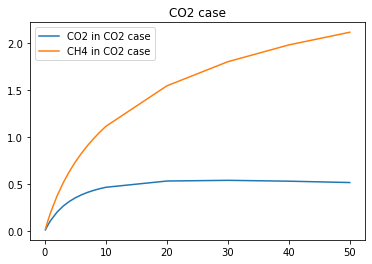

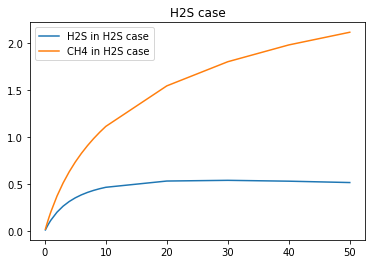

In [27]:
plt.figure()
plt.plot(p_range,qq_CO2_CO2,label = 'CO2 in CO2 case')
plt.plot(p_range,qq_CO2_CH4,label = 'CH4 in CO2 case')
plt.title("CO2 case")
plt.legend()

plt.figure()
plt.plot(p_range,qq_H2S_H2S,label = 'H2S in H2S case')
plt.plot(p_range,qq_H2S_CH4,label = 'CH4 in H2S case')
plt.title("H2S case")
plt.legend()

# Optimization work for modification factor

## TESTING the Concept

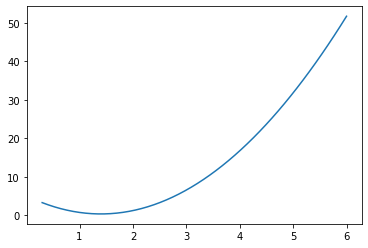

In [30]:
# Consider :
# optim.least_squares()
def M_CO2_CO2(M):
    dif = q_CO2_CO2 - M*qq_CO2_CO2 # (GCMC result) - M x (IAST result)
    return np.sum(dif**2)

## Testing the modification factor
m_ran = np.linspace(0.3,6)
dif_list = []
for mm in m_ran:
    res_tmp = M_CO2_CO2(mm)
    dif_list.append(res_tmp)
plt.plot(m_ran,dif_list)

## Plot the errors

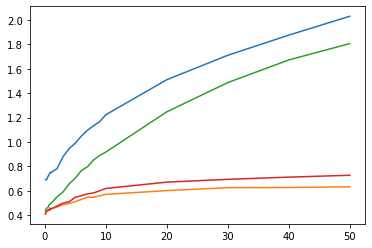

In [123]:
plt.plot(p_range, q_CO2_CO2/qq_CO2_CO2)
plt.plot(p_range, q_CO2_CH4/qq_CO2_CH4)
plt.plot(p_range, q_H2S_H2S/qq_H2S_H2S)
plt.plot(p_range, q_H2S_CH4/qq_H2S_CH4)

## All the objective function for modification factor

In [223]:
def Lang(p_in,mmm,kkk):
    return mmm*p_in*kkk/(1+ p_in*kkk)

def M_CO2_CO2(M):
    MM= M[0]
    K = M[1]
    x_mod = MM*p_range*0.5*K/(1+p_range*K*0.5)
    dif = q_CO2_CO2 - x_mod*qq_CO2_CO2 # (GCMC result) - M x (IAST result)
    return np.sum(dif**2)
def M_CO2_CH4(M):
    dif = q_CO2_CH4 - M*qq_CO2_CH4 # (GCMC result) - M x (IAST result)
    return np.sum(dif**2)
def M_H2S_H2S(M):
    MM= M[0]
    K = M[1]
    x_mod = MM*p_range*K*0.5/(1+p_range*K*0.5)
    dif = q_H2S_H2S - x_mod*qq_H2S_H2S # (GCMC result) - M x (IAST result)
    return np.sum(dif**2)
def M_H2S_CH4(M):
    dif = q_H2S_CH4 - M*qq_H2S_CH4 # (GCMC result) - M x (IAST result)
    return np.sum(dif**2)    

In [224]:
m_co2co2 = optim.least_squares(M_CO2_CO2, [1.5, 0.1])
print('M_CO2_CO2 = ', m_co2co2)
m_co2ch4 = optim.least_squares(M_CO2_CH4, 1.5)
print('M_CO2_CH4 = ', m_co2ch4)
m_h2sh2s = optim.least_squares(M_H2S_H2S, [2, 0.1])
print('M_H2S_H2S = ', m_h2sh2s)
m_h2sch4 = optim.least_squares(M_H2S_CH4, 1.5)
print('M_H2S_CH4 = ', m_h2sch4)


M_CO2_CO2 =   active_mask: array([0., 0.])
        cost: 0.00044950754054363766
         fun: array([0.02998358])
        grad: array([-1.14517599e-06, -3.97678149e-07])
         jac: array([[-3.81934372e-05, -1.32631976e-05]])
     message: '`ftol` termination condition is satisfied.'
        nfev: 130
        njev: 129
  optimality: 1.1451759870930875e-06
      status: 2
     success: True
           x: array([2.14944488, 0.30340749])
M_CO2_CH4 =   active_mask: array([0.])
        cost: 0.000725749052011027
         fun: array([0.03809853])
        grad: array([-7.42000054e-07])
         jac: array([[-1.94758177e-05]])
     message: '`ftol` termination condition is satisfied.'
        nfev: 21
        njev: 13
  optimality: 7.420000537835645e-07
      status: 2
     success: True
           x: array([0.59677698])
M_H2S_H2S =   active_mask: array([0., 0.])
        cost: 0.00014684310867972233
         fun: array([0.01713728])
        grad: array([-2.83266372e-05, -2.21663989e-05])
   

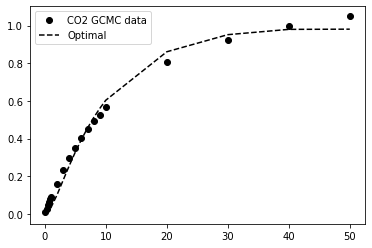

In [225]:
### Langmuir ###
msol = m_co2co2.x[0]
ksol = m_co2co2.x[1]
plt.plot(p_range, q_CO2_CO2,'ko', label = 'CO2 GCMC data')
#plt.plot(p_range, msol*ksol*p_range/(1+ ksol*p_range)*qq_CO2_CO2,'k--', label = 'Modified')
plt.plot(p_range, Lang(p_range*0.5,msol,ksol)*qq_CO2_CO2,'k--', label = 'Optimal')
plt.legend()

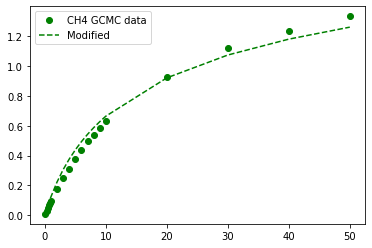

In [226]:
### Linear ###
msol = m_co2ch4.x
#ksol = m_co2ch4.x[1]
plt.plot(p_range, q_CO2_CH4,'go', label = 'CH4 GCMC data')
plt.plot(p_range, msol*qq_CO2_CH4,'g--', label = 'Modified')
plt.legend()

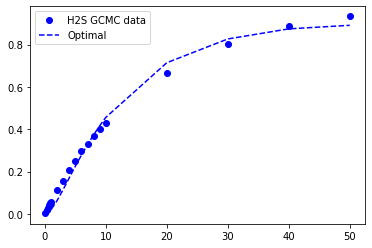

In [227]:
### Langmuir ###
msol = m_h2sh2s.x[0]
ksol = m_h2sh2s.x[1]
plt.plot(p_range, q_H2S_H2S,'bo', label = 'H2S GCMC data')
plt.plot(p_range, msol*ksol*p_range*0.5/(1+ ksol*p_range*0.5)*qq_H2S_H2S,'b--', label = 'Optimal')
plt.legend()

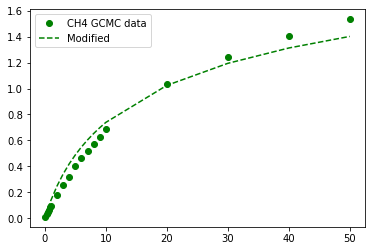

In [228]:
### Linear ###
msol = m_h2sch4.x
#ksol = m_co2ch4.x[1]
plt.plot(p_range, q_H2S_CH4,'go', label = 'CH4 GCMC data')
plt.plot(p_range, msol*qq_H2S_CH4,'g--', label = 'Modified')
plt.legend()

# Modified mixture isotherm

In [229]:
Arrh = lambda T,dH ,T_ref: np.exp(-dH/8.3145*(1/T - 1/T_ref)) # Arrhenius equation (Clasius-Clapeyron Equation)

## Isothermal mixture isotherm
def iso_mix_modi(P_par, T, iso_list, dH_list,Tref_list, modi):
    P_norm = []
    M_la = modi[0] # Saturation uptake of Langmuir
    K_la = modi[1] # equilibrium constatnt term of Langmuir
    M_he = modi[2] # Henry constatnt
    for (p,dh,tref) in zip(P_par, dH_list,Tref_list):
        p_n = Arrh(T,dh,tref)*p 
        P_norm.append(p_n)
    P_norm_arr = np.array(P_norm)
    #print(P_norm_mat.T)
    if P_norm_arr.ndim > 1:
        for i in range(len(P_norm[0])):
            p_tmp = P_norm_arr[i,:]
            p_tmp[p_tmp<0.000001] = 0.000001
            q_IAST_tmp = pyiast.iast(p_tmp,
                                     iso_list,
                                     warningoff=True)
    else:
        try:
            p_tmp = P_norm_arr
            p_tmp[p_tmp<0.000001] = 0.000001
            #print(p_tmp)
            q_IAST_tmp = pyiast.iast(p_tmp,
                                    iso_list,
                                     warningoff=True)
        except:    
            try:
                #print('Initial guess error with P = ',P_par)
                x_IG = np.ones(len(p_tmp))/len(p_tmp)
                q_IAST_tmp = pyiast.iast(p_tmp,
                                        iso_list,adsorbed_mole_fraction_guess = x_IG,
                                        warningoff=True)
            except:
                try:
                    arg_min = np.argmin(p_tmp)
                    p_tmp[p_tmp<0.000001] = 0.000001
                    x_IG = 0.05*np.ones(len(p_tmp))
                    x_IG[arg_min] = 1 - 0.05*(len(p_tmp)-1)
                    #print(x_IG)
                    q_IAST_tmp = pyiast.iast(p_tmp,
                                            iso_list,adsorbed_mole_fraction_guess = x_IG,
                                            warningoff=True)

                except:
                    try:
                        arg_max = np.argmax(p_tmp)
                        p_tmp[p_tmp<0.000001] = 0.000001
                        x_IG = 0.05*np.ones(len(p_tmp))
                        x_IG[arg_max] = 1 - 0.05*(len(p_tmp)-1)
                        #print(x_IG)
                        q_IAST_tmp = pyiast.iast(p_tmp,
                                                iso_list,adsorbed_mole_fraction_guess = x_IG,
                                                warningoff=True)        
                    except:
                        try:
                            arg_max = np.argmax(p_tmp)
                            p_tmp[p_tmp<0.000001] = 0.000001
                            x_IG = 0.15*np.ones(len(p_tmp))
                            x_IG[arg_max] = 1 - 0.15*(len(p_tmp)-1)
                            #print(x_IG)
                            q_IAST_tmp = pyiast.iast(p_tmp,
                                                iso_list,adsorbed_mole_fraction_guess = x_IG,
                                                warningoff=True)
                        except:
                            try:
                                arg_min = np.argmin(p_tmp)
                                p_tmp[p_tmp<0.000001] = 0.000001
                                x_IG = 0.01*np.ones(len(p_tmp))
                                x_IG[arg_min] = 1 - 0.01*(len(p_tmp)-1)
                                #print(x_IG)
                                q_IAST_tmp = pyiast.iast(p_tmp,
                                            iso_list,adsorbed_mole_fraction_guess = x_IG,
                                            warningoff=True)

                            except:
                                try:
                                    arg_max = np.argmax(p_tmp)
                                    p_tmp[p_tmp<0.000001] = 0.000001
                                    x_IG = 0.01*np.ones(len(p_tmp))
                                    x_IG[arg_max] = 1 - 0.01*(len(p_tmp)-1)
                                    #print(x_IG)
                                    q_IAST_tmp = pyiast.iast(p_tmp,
                                                    iso_list,adsorbed_mole_fraction_guess = x_IG,
                                                warningoff=True)        
                                except:
                                    p_tmp[p_tmp<0.000001] = 0.000001
                                    x_IG = [0.9999, 0.0001]
                                    #print(x_IG)
                                    q_IAST_tmp = pyiast.iast(p_tmp,
                                                    iso_list,adsorbed_mole_fraction_guess = x_IG,
                                                warningoff=True)    
    q_re0 = Lang(P_par[0], M_la,K_la)* q_IAST_tmp[0]
    q_re1 = M_he* q_IAST_tmp[1]
    #return q_IAST_tmp
    return [q_re0, q_re1]

In [230]:
m_co2co2.x[0]

2.149444882635398

## Test with CO2 case

In [238]:
isomixmodi_list_tmp0 = []
isomixmodi_list_tmp1 = []
for pp in p_range:
    q_mix_tmp = iso_mix_modi(pp*np.array([0.5,0.5]), 343, bins_IWR0_CO2, dH_IWR0_CO2, [298,298],
                             [m_co2co2.x[0], m_co2co2.x[1],m_co2ch4.x])
    isomixmodi_list_tmp0.append(q_mix_tmp[0])
    isomixmodi_list_tmp1.append(q_mix_tmp[1])
#iso_mix_modi()

Text(0, 0.5, 'Uptake (mol/kg)')

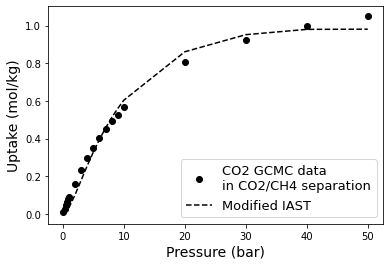

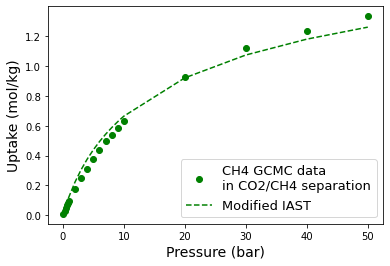

In [239]:
plt.figure()
plt.plot(p_range, q_CO2_CO2, 'ko',
         label = 'CO2 GCMC data \nin CO2/CH4 separation')
plt.plot(p_range, isomixmodi_list_tmp0,'k--',
        label = 'Modified IAST')
plt.legend(fontsize = 13)
plt.xlabel('Pressure (bar)',fontsize = 14)
plt.ylabel('Uptake (mol/kg)',fontsize = 14)

plt.figure()
plt.plot(p_range, q_CO2_CH4, 'go',
        label = 'CH4 GCMC data \nin CO2/CH4 separation')
plt.plot(p_range, isomixmodi_list_tmp1, 'g--',
        label = 'Modified IAST')
plt.legend(fontsize=13)
plt.xlabel('Pressure (bar)',fontsize = 14)
plt.ylabel('Uptake (mol/kg)',fontsize = 14)

## Test with H2S case

In [240]:
isomixmodi_list_tmp0 = []
isomixmodi_list_tmp1 = []
for pp in p_range:
    q_mix_tmp = iso_mix_modi(pp*np.array([0.5,0.5]), 343, bins_IWR0_H2S, dH_IWR0_H2S, [298,298],
                             [m_h2sh2s.x[0], m_h2sh2s.x[1],m_h2sch4.x])
    isomixmodi_list_tmp0.append(q_mix_tmp[0])
    isomixmodi_list_tmp1.append(q_mix_tmp[1])
#iso_mix_modi()

Text(0, 0.5, 'Uptake (mol/kg)')

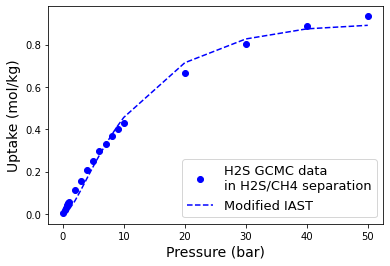

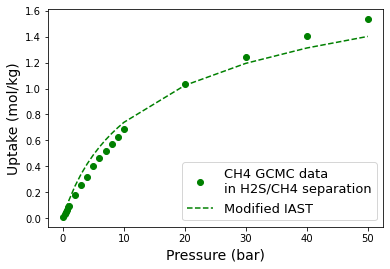

In [241]:
plt.figure()
plt.plot(p_range, q_H2S_H2S, 'bo',
         label = 'H2S GCMC data \nin H2S/CH4 separation')
plt.plot(p_range, isomixmodi_list_tmp0,'b--',
        label = 'Modified IAST')
plt.legend(fontsize = 13)
plt.xlabel('Pressure (bar)',fontsize = 14)
plt.ylabel('Uptake (mol/kg)',fontsize = 14)

plt.figure()
plt.plot(p_range, q_H2S_CH4, 'go',
        label = 'CH4 GCMC data \nin H2S/CH4 separation')
plt.plot(p_range, isomixmodi_list_tmp1, 'g--',
        label = 'Modified IAST')
plt.legend(fontsize=13)
plt.xlabel('Pressure (bar)',fontsize = 14)
plt.ylabel('Uptake (mol/kg)',fontsize = 14)

In [236]:
Param_names = ['M_lang', 'K_lang', 'M_hen']
x_modi_CO2= [m_co2co2.x[0], m_co2co2.x[1], m_co2ch4.x[0]]
x_modi_H2S= [m_h2sh2s.x[0], m_h2sh2s.x[1], m_h2sch4.x[0]]
di_tmp = {'Modification Facto': Param_names,
         'CO2 case':x_modi_CO2,
         'H2S case':x_modi_H2S}
df_tmp = pd.DataFrame(di_tmp)
df_tmp.to_csv('Modificaiton_factors_IWR0.csv' , index= False)

In [222]:
df_tmp

,Modification Facto,CO2 case,H2S case
0,M_lang,2.149445,2.131048
1,K_lang,0.303407,0.169714
2,M_hen,0.596777,0.663861
